코랩에서는 노트설정 TPU로 설정

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.7.0
Running on TPU  ['10.72.194.146:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.72.194.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.194.146:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# CNN

## 이미지 처리

In [ ]:
mnist_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
mnist_test = pd.read_csv('/content/sample_data/mnist_test.csv')

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11501568/11490434 [==============================] - 0s 0us/step


### 이미지 확인

In [ ]:
y_train[0]

5

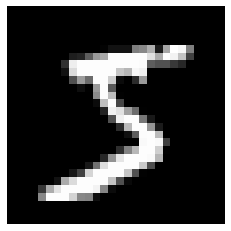

In [ ]:
plt.imshow( x_train[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

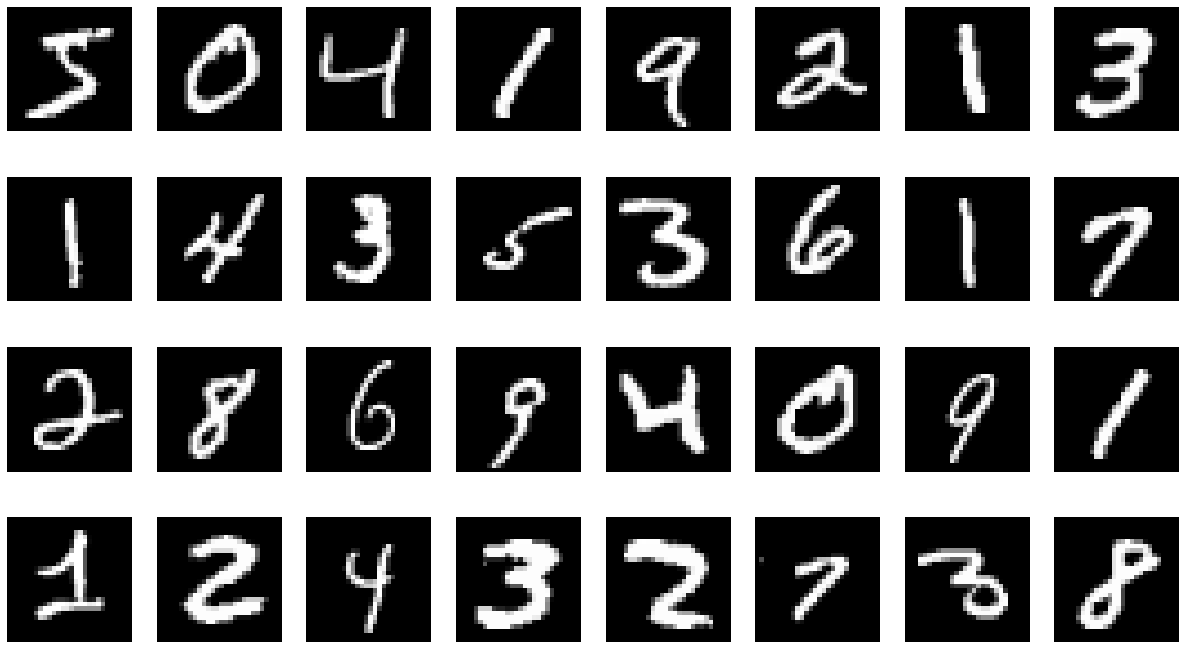

In [ ]:
plt.figure( figsize=(21, 12) )
for i in range(32):
  plt.subplot(4, 8, 1 + i)
  plt.imshow( x_train[i].reshape(28, 28), cmap='gray')
  plt.axis('off')

- 0에서 9 사이의 숫자들의 손글씨를 이미지로 만든 것
- 분류 모형을 이용해 이 숫자들의 분류기를 만들 것임
- 케라스에서는 convolution을 layer로 취급함

### Convolution

In [ ]:
# edge detection
kernel1 = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]], dtype=np.float64).reshape(3, 3, 1, 1)

# sharpen
kernel2 = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]], dtype=np.float64).reshape(3, 3, 1, 1)

# box blur
kernel3 = np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1],], dtype=np.float64).reshape(3, 3, 1, 1) * 1/9

In [ ]:
@tf.function
def convolution( img, kernel ):
  return tf.nn.conv2d( img, kernel, strides=[1, 1, 1, 1], padding='VALID')

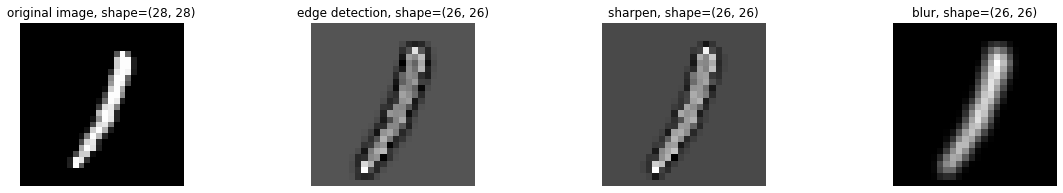

In [ ]:
img = tf.reshape( x_train[99], shape=[-1, 28, 28, 1] )
out1 = convolution( img, kernel1 )
out2 = convolution( img, kernel2 )
out3 = convolution( img, kernel3 )

plt.figure( figsize=(20, 3) )
plt.subplot( 1, 4, 1 )
plt.title(f'original image, shape={x_train[99].shape}')
plt.imshow( x_train[99], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 2 )
plt.title(f'edge detection, shape={out1[0, :, :, 0].shape}')
plt.imshow( out1[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 3 )
plt.title(f'sharpen, shape={out2[0, :, :, 0].shape}')
plt.imshow( out2[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 4 )
plt.title(f'blur, shape={out3[0, :, :, 0].shape}')
plt.imshow( out3[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.show()

#### strides
- 슬라이딩 윈도우를 하기 위한 값
 - 합성곱을 하기 위해 쭉 훑는 과정
- 슬라이딩 윈도우를 하기 위한 간격

#### padding
- 이미지 바깥 영역에 제로 패딩을 넣어서 슬라이딩 진행
- 엣지에 있는 값들을 살리기 위함
- SAME : 제로 패딩을 넣어서 feature 추출
- VALID : 제로 패딩을 넣지 않기 때문에 테두리 부분이 점점 희미해지면서 이미지 사이즈가 작아짐

### Pooling

In [ ]:
@tf.function
def pooling( img ):
  max_pool_2d = tf.keras.layers.MaxPool2D((2, 2))
  return max_pool_2d(img)

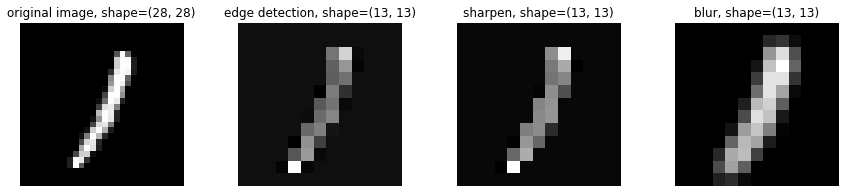

In [ ]:
ret1 = pooling( out1 )
ret2 = pooling( out2 )
ret3 = pooling( out3 )

plt.figure( figsize=(15, 3) )
plt.subplot( 1, 4, 1 )
plt.title(f'original image, shape={x_train[99].shape}')
plt.imshow( x_train[99], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 2 )
plt.title(f'edge detection, shape={ret1[0, :, :, 0].shape}')
plt.imshow( ret1[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 3 )
plt.title(f'sharpen, shape={ret2[0, :, :, 0].shape}')
plt.imshow( ret2[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 4 )
plt.title(f'blur, shape={ret3[0, :, :, 0].shape}')
plt.imshow( ret3[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.show()

#### strides
- 슬라이딩 윈도우를 하기 위한 값
 - 합성곱을 하기 위해 쭉 훑는 과정
- 슬라이딩 윈도우를 하기 위한 간격

#### padding
- 이미지 바깥 영역에 제로 패딩을 넣어서 슬라이딩 진행
- 엣지에 있는 값들을 살리기 위함
- SAME : 제로 패딩을 넣어서 feature 추출
- VALID : 제로 패딩을 넣지 않기 때문에 테두리 부분이 점점 희미해지면서 이미지 사이즈가 작아짐

### Pooling

In [ ]:
@tf.function
def pooling( img ):
  max_pool_2d = tf.keras.layers.MaxPool2D((2, 2))
  return max_pool_2d(img)

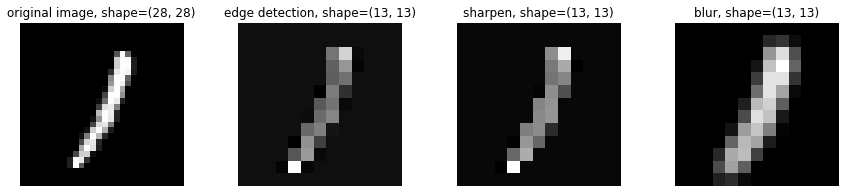

In [ ]:
ret1 = pooling( out1 )
ret2 = pooling( out2 )
ret3 = pooling( out3 )

plt.figure( figsize=(15, 3) )
plt.subplot( 1, 4, 1 )
plt.title(f'original image, shape={x_train[99].shape}')
plt.imshow( x_train[99], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 2 )
plt.title(f'edge detection, shape={ret1[0, :, :, 0].shape}')
plt.imshow( ret1[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 3 )
plt.title(f'sharpen, shape={ret2[0, :, :, 0].shape}')
plt.imshow( ret2[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 4 )
plt.title(f'blur, shape={ret3[0, :, :, 0].shape}')
plt.imshow( ret3[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.show()

## 이미지 넷 구축(mnist)
- convo1 * pooling 3번 진행해보기

In [ ]:
model = tf.keras.models.Sequential()

# Convolution Layer
model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
#pooling layer
model.add( tf.keras.layers.MaxPool2D((2,2)) )

# Convolution Layer
model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
#pooling layer
model.add( tf.keras.layers.MaxPool2D((2,2)) )

# Convolution Layer
model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
#pooling layer
model.add( tf.keras.layers.MaxPool2D((2,2)) )

# neural net의 입력으로 넣기 위해 1차원으로 변경하기
model.add(tf.keras.layers.Flatten())

# Neural net 구성하기
# hidden layer
model.add(tf.keras.layers.Dense(4096,activation='tanh'))
model.add(tf.keras.layers.Dense(4096,activation='tanh'))

# output layer
model.add(tf.keras.layers.Dense(10,activation='softmax')) # 분류모형의 마지막 activation는 항상 softmax

# optimization
model.compile(
  loss = 'sparse_categorical_crossentropy',
  metrics = ['accuracy'],
  optimizer = 'Adam'
)

In [ ]:
hist = model.fit(x_train, y_train, epochs=10, batch_size=1000, validation_split=0.2)

Epoch 1/10
48/48 [==============================] - 9s 174ms/step - loss: 0.5350 - accuracy: 0.8323 - val_loss: 0.1532 - val_accuracy: 0.9533
Epoch 2/10
48/48 [==============================] - 8s 163ms/step - loss: 0.1374 - accuracy: 0.9589 - val_loss: 0.1168 - val_accuracy: 0.9647
Epoch 3/10
48/48 [==============================] - 8s 163ms/step - loss: 0.0969 - accuracy: 0.9713 - val_loss: 0.0940 - val_accuracy: 0.9698
Epoch 4/10
48/48 [==============================] - 8s 166ms/step - loss: 0.0746 - accuracy: 0.9772 - val_loss: 0.0907 - val_accuracy: 0.9737
Epoch 5/10
48/48 [==============================] - 8s 162ms/step - loss: 0.0608 - accuracy: 0.9812 - val_loss: 0.0726 - val_accuracy: 0.9785
Epoch 6/10
48/48 [==============================] - 8s 163ms/step - loss: 0.0461 - accuracy: 0.9856 - val_loss: 0.0738 - val_accuracy: 0.9781
Epoch 7/10
48/48 [==============================] - 8s 163ms/step - loss: 0.0416 - accuracy: 0.9867 - val_loss: 0.0915 - val_accuracy: 0.9739
Epoch 

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### 학습 정확도

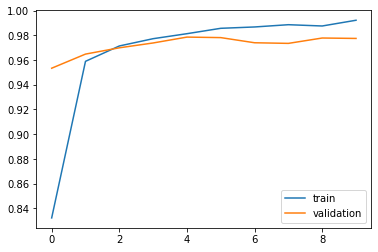

In [ ]:
plt.plot( hist.history['accuracy'], label='train')
plt.plot( hist.history['val_accuracy'], label='validation') # 검증정확도(테스트 사용)
plt.legend()
plt.show()

### 손실함수

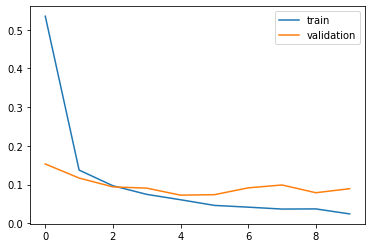

In [ ]:
plt.plot( hist.history['loss'], label='train')
plt.plot( hist.history['val_loss'], label='validation') # 검증정확도
plt.legend()
plt.show()

### 예측
- 학습에 사용 안된 test set을 이용

In [ ]:
print(y_test[1000])

9


In [ ]:
yhat=model.predict(x_test)

In [ ]:
print(yhat[1000]) # 99%의 확률로 9로 예측
print(np.argmax(yhat[1000]))

[6.4179800e-11 5.1456514e-08 9.9446059e-12 2.3792416e-05 1.0517671e-07
 1.3952733e-07 3.5901691e-15 5.2632866e-03 1.0135038e-08 9.9471271e-01]
9


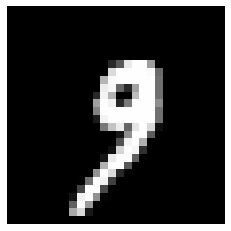

In [ ]:
plt.imshow( x_test[1000], cmap='gray')
plt.axis('off')
plt.show()